# Report 1: Parameter estimation using Monte Carlo simulations

In [223]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline
from iminuit import Minuit
import random
import timeit
import math
from scipy.optimize import minimize

## Analysis of probability distribution

In this report, we will be analysing a decay process X -> D which can be caractarised by the folowing probaboility distribution:
\begin{equation}
P(t;\tau, \Delta m_s, V) \;\; \alpha \;\; (1 + Vsin(\Delta mt)) \cdot e^{-t/\tau}
\end{equation}

We note that the above equation is only proportionate and is unormalised. In order to make the above equation a PDF we would need to add a normalisation factior, $t_{norm}$.

In this section of the report, we will create a lambda function to analise the functional form of the drobability distribution in order to help us later on in the analysis.

We are told to look at this distribution within the bounds of $t \in [0, 10]$

In [224]:
# Lambda function of pdf
distribution = lambda t, tau, delta_mass, V : (1 + V*np.sin(delta_mass*t))*np.exp(-t/tau)

# We define function bounds and time values
X_BOUNDS = (0, 10)

# Define the time values
n_steps = 1000                           # For now we will plot 100 points within the bounds
t = np.linspace(*X_BOUNDS, n_steps, endpoint=True)


We now pick different sets of parameters ot investigate how they afect the functional form of the distribution. From looking at the equation, we can expect the function to take a decaying sinusoidal form with $\tau$ being the decay constant, V be the amplitude of the harmonic component and $\Delta m_s$ to be the angular frequency of the harmonic

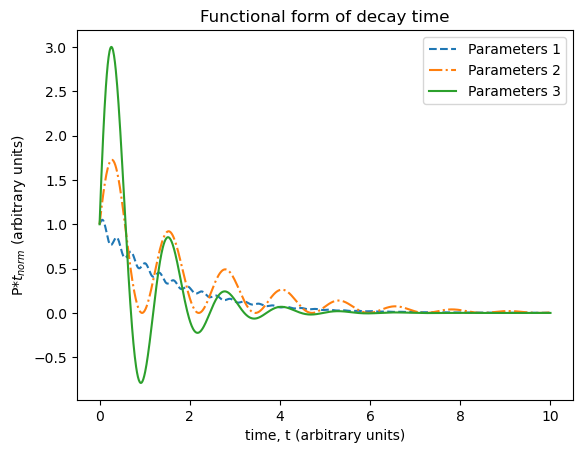

In [225]:
# Choosing different parameters (tau, delta_mass, Potential)
parameters_1 = (1.5, 20, 0.1)
parameters_2 = (2.0, 5.0, 1.0)
parameters_3 = (1.0, 5.0, 3.0)

# We plot the function for these parameters
plt.plot(t, distribution(t, *parameters_1), label="Parameters 1", ls="--")
plt.plot(t, distribution(t, *parameters_2), label="Parameters 2", ls="-.")
plt.plot(t, distribution(t, *parameters_3), label="Parameters 3", ls="-")
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Functional form of decay time")
plt.legend()

We will need to create an algorithm to randomly draw a value within this distribution. There are multiple methods for us to do so.

Let us try to use the box method for a start. We note that in this case as the minimum value of the distribution is not zero, We will need to identify the max and min point of the distriution in order for us to define the box around the distribution.

We will test our function by trying to find the maximum and minimum point of the function using parameters_1, which from the plot we expect a y_max of ~ 3.0 and y_min of ~ -0.8

In [226]:
# Function to find max point of the distribution
def find_max(function, bound_low, bound_high, parameters=parameters_3, grid=100000,):
    """
    Return the maximum value of a function
    """
    # Note that grid defines the number of steps within thedefined range
    if (not grid >= 0):
        raise ValueError("Grid must be a a positive intiger")
    # Generate grid of x values
    x = np.linspace(bound_low, bound_high, num=grid, endpoint=True,)
    # Compute and return the maximum point of function
    y = function(x, *parameters)
    return x[y.argmax()], y.max()

# Function to find min point of the distribution
def find_min(function, bound_low, bound_high, parameters=parameters_3, grid=100000,):
    """
    Return the minimum value of a function
    """
    # Note that grid defines the number of steps within thedefined range
    if (not grid >= 0):
        raise ValueError("Grid must be a a positive intiger")
    # Generate grid of x values
    x = np.linspace(bound_low, bound_high, num=grid, endpoint=True,)
    # Compute and return the minimum point of function
    y = function(x, *parameters)
    return x[y.argmin()], y.min()

x_peak_max, y_max = find_max(distribution, *X_BOUNDS)
x_peak_min, y_min = find_min(distribution, *X_BOUNDS)
Y_BOUNDS = (y_min, y_max)

print(f"Maximum point of distribution with parameters_1 is {y_max:.3f}")
print(f"Minimum point of distribution with parameters_1 is {y_min:.3f}")

Maximum point of distribution with parameters_1 is 3.000
Minimum point of distribution with parameters_1 is -0.790


Now that we have obtained the maximum and minimum points, we will attempt to implement an algoritm to randomly draw values within this distribution using the box method.

In [227]:
def box_method(func, x_min, x_max, y_min, y_max):
    while True:
        x = np.random.uniform(x_min, x_max)
        y_function = func(x, *parameters_3)
        y_box = np.random.uniform(y_min, y_max)
        if y_box <= y_function:
            return (x, y_box)

We now generate 5000 random points and check they are within the bounds of the distribution

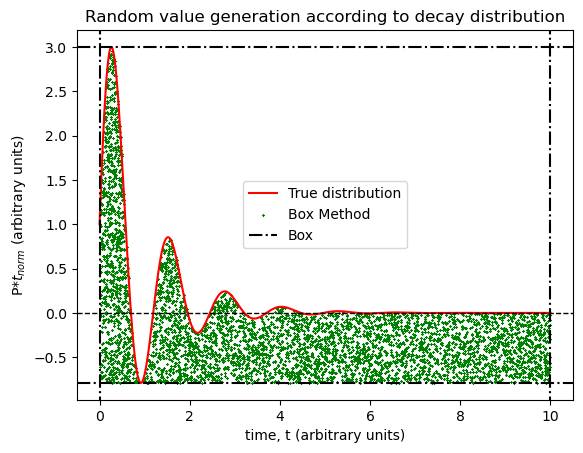

In [228]:
random_points_x = []
random_points_y = []
n_random_points = 5000

# Generate 5000 points
for _ in range(n_random_points):
    x, y = box_method(distribution, *X_BOUNDS, *Y_BOUNDS)
    random_points_x.append(x)
    random_points_y.append(y)

# Plot function and points
plt.plot(t, distribution(t, *parameters_3), label="True distribution", c="red")
plt.scatter(random_points_x, random_points_y, s=0.7, marker="x", c="g", label="Box Method")
plt.axhline(0, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="--", c="black", linewidth=1)
plt.axhline(y_min, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="-.", c="black", linewidth=1.5, label="Box")
plt.axhline(y_max, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="-.", c="black", linewidth=1.5,)
plt.axvline(X_BOUNDS[0], ymin=y_min, ymax=y_max, linestyle="-.", c="black", linewidth=1.5,)
plt.axvline(X_BOUNDS[1], ymin=y_min, ymax=y_max, linestyle="-.", c="black", linewidth=1.5,)
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Random value generation according to decay distribution")
plt.legend()


We notice that we are getting random points being drawn below the function line. But this is not what is required. We require the random points to be drawn from the area bounded between the function line and the x axis. As a result, to fix this, we must discriminate random points where $y_{func}$ is above and below the x axis. Fow points where $y_{func}$ is negative, we accept $y_{box}$ if it is greater than $y_{func}$.

We write the fixed function below and re-generate 5000 random points ot see if it is working:

In [229]:
def box_method_fixed(func, x_min, x_max, y_min, y_max):
    while True:
        x = np.random.uniform(x_min, x_max)
        y_function = func(x, *parameters_3)
        y_box = np.random.uniform(y_min, y_max)
        # Accept condition if y_function is above x axis
        if (y_function >= 0.0) and (y_box>= 0.0) and (y_box <= y_function):
            return (x, y_box)
        # Accept condition if y_function is below x axis
        if (y_function <= 0.0) and (y_box <= 0) and (y_box >= y_function):
            return (x, y_box)

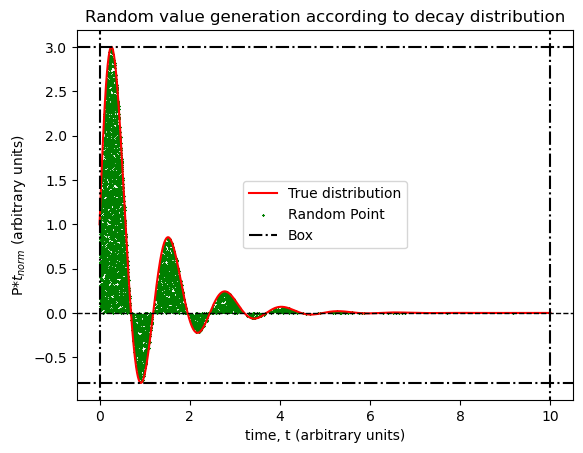

In [230]:
random_points_x = []
random_points_y = []
n_random_points = 5000

# Generate 5000 points
for _ in range(n_random_points):
    x, y = box_method_fixed(distribution, *X_BOUNDS, *Y_BOUNDS)
    random_points_x.append(x)
    random_points_y.append(y)

# Plot function and points
plt.plot(t, distribution(t, *parameters_3), label="True distribution", c="red")
plt.scatter(random_points_x, random_points_y, s=0.7, marker="x", c="g", label="Random Point")
plt.axhline(0, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="--", c="black", linewidth=1)
plt.axhline(y_min, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="-.", c="black", linewidth=1.5, label="Box")
plt.axhline(y_max, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="-.", c="black", linewidth=1.5,)
plt.axvline(X_BOUNDS[0], ymin=y_min, ymax=y_max, linestyle="-.", c="black", linewidth=1.5,)
plt.axvline(X_BOUNDS[1], ymin=y_min, ymax=y_max, linestyle="-.", c="black", linewidth=1.5,)
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Random value generation according to decay distribution")
plt.legend()

Now that we have a function capable of generating random points, we can look to optimise it in order to speed up the MC simulation. 

For now we will keep using the box method (although it is not the most optimal) and will look to shave time another way. It is known that when using in built python types, It is quicker to python libraries rather than numpy where possible. Hence we will replace the lambda function and the box method algorith to use the math and random packages instead and compare the computation times.

In [231]:
# Rewrite the lambda function to use the python math function
distribution_optimised = lambda t, tau, delta_mass, V : (1 + V*math.sin(delta_mass*t))*math.exp(-t/tau)

# Rewrite the box method algoritm to use the new function and to use random library
def box_method_optimised(func, x_min, x_max, y_min, y_max):
    while True:
        x = random.uniform(x_min, x_max)
        y_function = func(x, *parameters_3)
        y_box = random.uniform(y_min, y_max)
        # Accept condition if y_function is above x axis
        if (y_function >= 0.0) and (y_box>= 0.0) and (y_box <= y_function):
            return (x, y_box)
        # Accept condition if y_function is below x axis
        if (y_function <= 0.0) and (y_box <= 0) and (y_box >= y_function):
            return (x, y_box)

Using the timeit function, we can now look at different combinations to see how the average function time takes.

The three combinations we will look at is:
* Function w/ Numpy + Random generator w/ Numpy
* Function w/ Math + Random generator w/ Numpy
* Function w/ Numpy + Random generator w/ Math
* Function w/ Math + Random generator w/ Math

In [232]:
print("\ntimeit resuts for: Function w/ Numpy + Random generator w/ Numpy")
%timeit box_method_fixed(distribution, *X_BOUNDS, *Y_BOUNDS)

print("\ntimeit resuts for: Function w/ Math + Random generator w/ Numpy")
%timeit box_method_fixed(distribution_optimised, *X_BOUNDS, *Y_BOUNDS)

print("\ntimeit resuts for: Function w/ Numpy + Random generator w/ Math")
%timeit box_method_optimised(distribution, *X_BOUNDS, *Y_BOUNDS)

print("\ntimeit resuts for: Function w/ Math + Random generator w/ Math")
%timeit box_method_optimised(distribution_optimised, *X_BOUNDS, *Y_BOUNDS)


timeit resuts for: Function w/ Numpy + Random generator w/ Numpy
88.8 µs ± 876 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

timeit resuts for: Function w/ Math + Random generator w/ Numpy
62.3 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

timeit resuts for: Function w/ Numpy + Random generator w/ Math
38.8 µs ± 759 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

timeit resuts for: Function w/ Math + Random generator w/ Math
10.8 µs ± 111 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


As we can see, by switching to both a box method algorithm and function that use python's standard libraries, we have optimised our MC simulation ~ 6 fold (~80% increase). This will provide a noticable difference when we are generating large datasets.

The previous method assumed that the function could take negative values. If we assume the oppposite (ie the range of V is $\in [0, 1]$), we can take afurther step to optimisation by changing the shape of the area where we draw our random values from a box to a triangle. We will pick the peak of the triangle to be the located at the point t = 0 and the triangle will have a hight corresponding to the highest point in the distribution. This will ensure we have an area that compleatly encompases our distribution given the previous assumptions.

Below we visualise the traingle compared to the box used previously. From now on we will be using values for the parameter V within $\in [0, 1]$.

The slope of the line defining the triangle is given by $m = -\frac{y_{max}}{x_max}$ and the y intercept is given by $y_{max}$

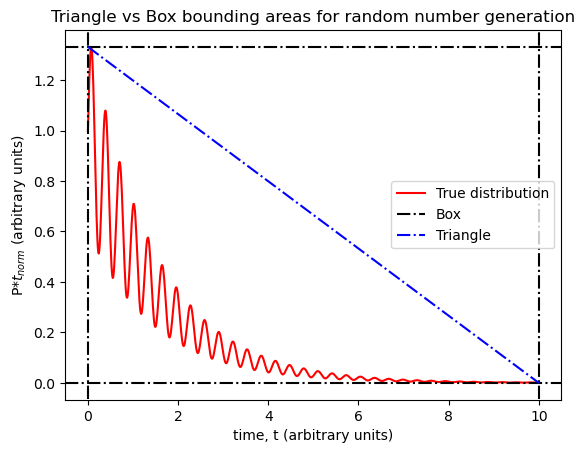

In [233]:
# Define variables for visualisation
parameters_4 = (1.5, 20.0, 0.4)
x_peak_max, y_max = find_max(distribution, *X_BOUNDS, parameters=parameters_4)
x_peak_mim, y_min = find_min(distribution, *X_BOUNDS, parameters=parameters_4)
Y_BOUNDS = (y_min, y_max)

# Visualisation of bounding box vs bounding triangle
# Plot distribution
plt.plot(t, distribution(t, *parameters_4), label="True distribution", c="red")
# Plot bounding box
plt.axhline(0.0, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="-.", c="black", linewidth=1.5, label="Box")
plt.axhline(y_max, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="-.", c="black", linewidth=1.5,)
plt.axvline(X_BOUNDS[0], ymin=y_min, ymax=y_max, linestyle="-.", c="black", linewidth=1.5,)
plt.axvline(X_BOUNDS[1], ymin=y_min, ymax=y_max, linestyle="-.", c="black", linewidth=1.5,)
# Plot bounding triangle
plt.plot(t, -(y_max/X_BOUNDS[1])*t+y_max, label="Triangle", c="blue", linewidth=1.5, linestyle="-.")

plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Triangle vs Box bounding areas for random number generation")
plt.legend()

As we can see, we have imediately cut a significant region of the box which would not have contributed to accepted random values. We should however note that this triangle method only works when $\tau$ is < ~2.6 a.u. This is because above 2.6 the distribution will start to xlip outside the box, resulting in a section of the distribution for which random numbers are not being generated.

Hence for the triangle we name two assumptions:
* $\tau$ is < 2.6 a.u
* V is within the bounds of [0, 1]

The nominal values for the parameters given to us fit these assumptions, hence we will build a triangle random number generatr and compare how quicker it is compared ot the box method

In [234]:
# Rewrite the box method algoritm to use a triangular bounding box
# Using assumption that all values of distribution are >= 0, we can drop out checks for values below 0
def triangle_method(func, x_min, x_max, y_min, y_max):
    while True:
        x = random.uniform(x_min, x_max)
        y_function = func(x, *parameters_4)
        y_triangle = random.triangular(y_min, y_max, y_min)
        # Accept condition if y_function is above x axis
        if (y_triangle <= y_function):
            return (x, y_triangle)

We can al;so try using a exponential boundung box to remove even more white space, although it is more complicated in picking a correct mean for the exponential

In [235]:
# Rewrite the box method algoritm to use a exponential bounding box
# Using assumption that all values of distribution are >= 0, we can drop out checks for values below 0
def exponential_method(func, x_min, x_max, y_min, y_max):
    while True:
        x = random.uniform(x_min, x_max)
        y_function = func(x, *parameters_4)
        while True:    
            # There is an optimal value for this exponential mean. For now we pick 4 given the nominal parameter values
            y_exp = random.expovariate(4)
            if (y_exp >= y_min) and (y_exp <= y_max):
                break
        # Accept condition if y_function is above x axis
        if (y_exp <= y_function):
            return (x, y_exp)

We now use this random value generator to generate random points and visualise them to assure that they are within our distribution

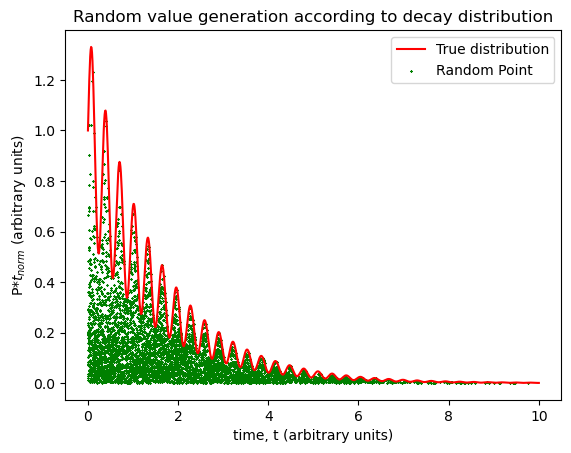

In [236]:
random_points_x = []
random_points_y = []
n_random_points = 5000

# Generate 5000 points
for _ in range(n_random_points):
    x, y = exponential_method(distribution, x_min=X_BOUNDS[0], x_max=X_BOUNDS[1], y_min=y_min, y_max=y_max)
    random_points_x.append(x)
    random_points_y.append(y)

# Plot function and points
plt.plot(t, distribution(t, *parameters_4), label="True distribution", c="red")
plt.scatter(random_points_x, random_points_y, s=0.7, marker="x", c="g", label="Random Point")
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Random value generation according to decay distribution")
plt.legend()

We now compare this method of generation with the unoptimised and optimised box method with timeit to see the imporvement in generation time

In [237]:
print("\ntimeit resuts for: Unoptimsed box method")
%timeit box_method_fixed(distribution, *X_BOUNDS, *Y_BOUNDS)

print("\ntimeit resuts for: Optimised box method")
%timeit box_method_optimised(distribution_optimised, *X_BOUNDS, *Y_BOUNDS)

print("\ntimeit resuts for: Triangle method")
%timeit triangle_method(distribution_optimised, *X_BOUNDS, *Y_BOUNDS)

print("\ntimeit resuts for: Exponential method")
%timeit exponential_method(distribution_optimised, *X_BOUNDS, *Y_BOUNDS)


timeit resuts for: Unoptimsed box method
53.6 µs ± 694 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

timeit resuts for: Optimised box method
6.43 µs ± 128 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

timeit resuts for: Triangle method
5.52 µs ± 68.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

timeit resuts for: Exponential method
2.33 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Our Improvements compared to the unoptimised method is ~10 fold, however our improvements compared to our optimised box method is margial. Irespective, given the triangle is still an improvement in run time and is the simplest to implemet, we will adopt the triangle method for the rest of the report

We can now create a class called ProbabilityDensityFunction which contains class methods and members to be shared for all probability density classes.
We also create a child class called HarmonicWithDecay which inherits ProbabilityDensityFunction and contain methods to generate random points in a distribution of this form and set different parameters

In [238]:
class ProbabilityDensityFunction(object):
    """
    Parent class containing common methods and members to be used by all pdf classes
    """

    def __init__(self, bounds):

        if (not isinstance(bounds, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (boundMin, boundMax)")
        if (not len(bounds) == 2):
            raise ValueError("Variable bound must have form (boundMin, boundMax)")
        if (not bounds[0] < bounds[1]):
            raise ValueError("First element in tuple must be smaller than second")
        
        # Initialise class variables
        self.boundMin, self.boundMax = bounds

        # Initialise array to contain generated events
        self.mass = []

    def integrate(self, limits):
        """
        Evaluate the integral of the pdf within the specified bounds
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not isinstance(limits, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (limitMin, limitMax)")
        if (not len(limits) == 2):
            raise ValueError("Variable bound must have form (limitMin, limitMax)")
        if (not limits[0] < limits[1]):
            raise ValueError("First element in tuple must be smaller than second")
        if (not limits[0] >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not limits[1] <= self.boundMax):
            raise ValueError("Higher integral limit must be smaller than upper bound of pdf")
    
        limitLow, limitHigh = limits
        integralResult, IntegralError = quad(self.evaluate, limitLow, limitHigh, limit=100) 
        return integralResult

    def getMass(self, flush=False):
        """
        Return numpy array containing all generated values.
        If flush is set to true, the masses of the class will be deleted once returned.
        """

        mass = np.array(self.mass)
        # flush masses if desired
        if flush:
            self.flushMass()

        return mass
    

    def flushMass(self,):
        """
        Empty the list containing the generated masses
        """

        self.mass.clear()


class HarmonicWithDecay(ProbabilityDensityFunction):
    """
    Class that will generate a random value according to a harminic signal with exponential decay
    """

    def __init__(self, tau, deltaMass, V, bounds):

        if (not isinstance(bounds, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (boundMin, boundMax)")
        if (not len(bounds) == 2):
            raise ValueError("Variable bound must have form (boundMin, boundMax)")
        if (not bounds[0] < bounds[1]):
            raise ValueError("First element in tuple must be smaller than second")

        # Initialise parent class
        super().__init__(bounds)

        # Initialise class variables
        self.boundMin, self.boundMax = bounds
        self.tau = tau
        self.deltaMass = deltaMass
        self.V = V 

        # Find maximum and minimum values of the distribution within the bounds
        self.maxValue = self._findMax()
        self.minValue = self._findMin()

    def _findMax(self, grid=100000,):
        """
        Return the maximum value of a function
        """
        # Note that grid defines the number of steps within thedefined range
        if (not grid >= 0):
            raise ValueError("Grid must be a a positive intiger")
        # Generate grid of x values
        x = np.linspace(self.boundMin, self.boundMax, num=grid, endpoint=True,)
        # Compute and return the maximum point of function
        y = self.evaluate(x)
        return y.max()

    def _findMin(self,grid=100000,):
        """
        Return the minimum value of a function
        """
        # Note that grid defines the number of steps within thedefined range
        if (not grid >= 0):
            raise ValueError("Grid must be a a positive intiger")
        # Generate grid of x values
        x = np.linspace(self.boundMin, self.boundMax, num=grid, endpoint=True,)
        # Compute and return the minimum point of function
        y = self.evaluate(x)
        return y.min()
    

    def evaluate(self, t,):
        """
        Evaluate the function of the distribution
        NOTE: Returns un-normalised values
        """
        
        return (1 + self.V*np.sin(self.deltaMass*t))*np.exp(-t/self.tau)

    def _evaluateOptimised(self, t):
        """
        Evatuate the function of the distribution when the t value passed is not a numpy array.
        Optimised for operations using python's fundamental types. This method is used in this class when generating
        random points from the distribution
        NOTE: Returns un-normalised values
        """

        return (1 + self.V*math.sin(self.deltaMass*t))*math.exp(-t/self.tau)

    def next(self,):
        """
        Generate a single random variable according to the class' distribution using the box method.
        Will return and append generated variable to mass list.
        """
        while True:
            x = random.uniform(self.boundMin, self.boundMax)
            y_function = self._evaluateOptimised(x,)
            y_box = random.uniform(self.minValue, self.maxValue, )
            # Accept condition if y_function is above x axis
            if (y_box <= y_function):
                self.mass.append(x)
                return (x, y_box)
        
    def setParameters(self, tau=None, deltaMass=None, V=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not tau == None:                     self.tau = tau
        if not deltaMass == None:               self.deltaMass = deltaMass       
        if not V == None:                       self.V = V     

class HarmonicWithDecay(ProbabilityDensityFunction):
    """
    Class that will generate a random value according to a harminic signal with exponential decay
    """

    def __init__(self, tau, deltaMass, V, bounds):

        if (not isinstance(bounds, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (boundMin, boundMax)")
        if (not len(bounds) == 2):
            raise ValueError("Variable bound must have form (boundMin, boundMax)")
        if (not bounds[0] < bounds[1]):
            raise ValueError("First element in tuple must be smaller than second")

        # Initialise parent class
        super().__init__(bounds)

        # Initialise class variables
        self.boundMin, self.boundMax = bounds
        self.tau = tau
        self.deltaMass = deltaMass
        self.V = V 

        # Find maximum and minimum values of the distribution within the bounds
        self.maxValue = self._findMax()
        self.minValue = self._findMin()

    def _findMax(self, grid=100000,):
        """
        Return the maximum value of a function
        """
        # Note that grid defines the number of steps within thedefined range
        if (not grid >= 0):
            raise ValueError("Grid must be a a positive intiger")
        # Generate grid of x values
        x = np.linspace(self.boundMin, self.boundMax, num=grid, endpoint=True,)
        # Compute and return the maximum point of function
        y = self.evaluate(x)
        return y.max()

    def _findMin(self,grid=100000,):
        """
        Return the minimum value of a function
        """
        # Note that grid defines the number of steps within thedefined range
        if (not grid >= 0):
            raise ValueError("Grid must be a a positive intiger")
        # Generate grid of x values
        x = np.linspace(self.boundMin, self.boundMax, num=grid, endpoint=True,)
        # Compute and return the minimum point of function
        y = self.evaluate(x)
        return y.min()
    

    def evaluate(self, t,):
        """
        Evaluate the function of the distribution
        NOTE: Returns un-normalised values
        """
        
        return (1 + self.V*np.sin(self.deltaMass*t))*np.exp(-t/self.tau)

    def _evaluateOptimised(self, t):
        """
        Evatuate the function of the distribution when the t value passed is not a numpy array.
        Optimised for operations using python's fundamental types. This method is used in this class when generating
        random points from the distribution
        NOTE: Returns un-normalised values
        """

        return (1 + self.V*math.sin(self.deltaMass*t))*math.exp(-t/self.tau)

    def next(self,):
        """
        Generate a single random variable according to the class' distribution using the box method.
        Will return and append generated variable to mass list.
        """
        while True:
            x = random.uniform(self.boundMin, self.boundMax)
            y_function = self._evaluateOptimised(x,)
            y_box = random.uniform(self.minValue, self.maxValue, )
            # Accept condition if y_function is above x axis
            if (y_box <= y_function):
                self.mass.append(x)
                return (x, y_box)
        
    def setParameters(self, tau=None, deltaMass=None, V=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not tau == None:                     self.tau = tau
        if not deltaMass == None:               self.deltaMass = deltaMass       
        if not V == None:                       self.V = V   

We will test the class by trying to recreate the plot using the nominal set of parameters 

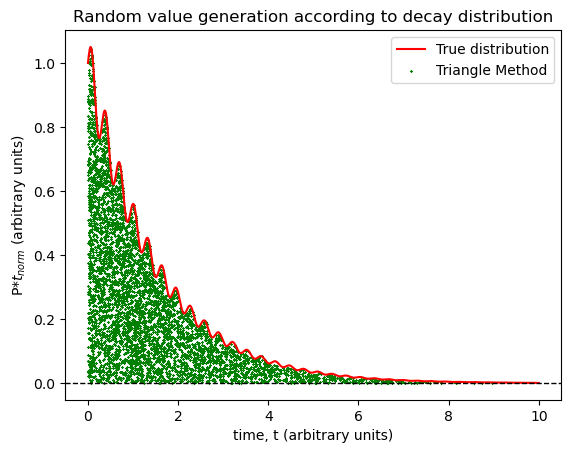

In [239]:
pdf = HarmonicWithDecay(tau=1.5, deltaMass=20.0, V=0.1, bounds=X_BOUNDS)

random_points_x = []
random_points_y = []
n_random_points = 5000

# Generate 5000 points
for _ in range(n_random_points):
    x, y = pdf.next()
    random_points_x.append(x)
    random_points_y.append(y)

# Plot function and points
plt.plot(t, pdf.evaluate(t,), label="True distribution", c="red") 
plt.scatter(random_points_x, random_points_y, s=0.7, marker="x", c="g", label="Triangle Method")
plt.axhline(0, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="--", c="black", linewidth=1)
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Random value generation according to decay distribution")
plt.legend()

As we can see from the plot, We have succesfully created a class which can generate points from the decay distribution.

We will now generate a toy dataset of times drawn from the harmonic w/ exponential decay distribution using our new class.
For this we will use the nominal parameter values provided. We can then plot a histogram with out toy dataset.

Text(0.5, 1.0, 'Histogram of toy dataset using nominal value of parameters')

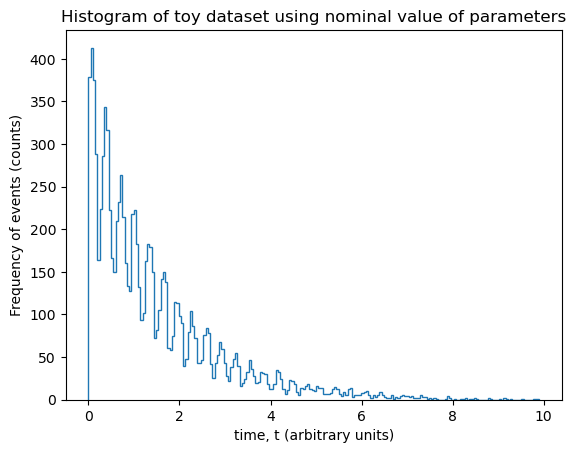

In [249]:
# Define nominal parameter values
nominal_tau = 1.5
nominal_delta_mass = 20.0
nominal_V = 0.4

# Define number of events to be generated
n_events = 10000

# Prodice instance of class using nominal values
nominal_pdf = HarmonicWithDecay(tau=nominal_tau, deltaMass=nominal_delta_mass, V=nominal_V, bounds=X_BOUNDS)

# Generate 1000 events and store them
for _ in range(n_events):
    nominal_pdf.next()
# Return masses and delete them in the clas s.t the class can be reused for a new toy experiment
events = nominal_pdf.getMass(flush=True)
# Plot Histogram of toy dataset
_ = plt.hist(events, bins=200, histtype="step") 
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"Frequency of events (counts)")
plt.title("Histogram of toy dataset using nominal value of parameters")

We now look to use a maximum likelyhood fit to determine the precision of the each parameters of the distribution. To do so, we will need to fit 100 toy datasets. Before we do so, We will write a class which will contain the maximum likelihood statistic which will be used to minimise out fit. We will also look to fit the above toy dataset with iminuit in order to verify that we are indeed fitting the dataset correctly.

Below we write the maximum likelyhood class:

In [250]:
class NegativeLogLikelihood(object):
    """
    Class containing minimisation statistic to be for pdf fitting. The class takes in events as the input.
    """

    def __init__(self, pdf, data):

        self.pdf = pdf
        self.data = data

    def setData(self, data):
        """
        Assign data class member to new dataset for the reuse of this class
        """
        
        self.data = data

    def findNormalisationFactor(self,):
        """
        Find integral of pdf 
        """
        
        # Define integration limits
        normalisationLimits = (self.pdf.boundMin, self.pdf.boundMax)

        return self.pdf.integrate(normalisationLimits)
    
    def evaluate(self, tau, deltaMass, V):
        """
        Evaluate negative log likelihood statisctic for passed parameters
        """

        # set new parameters
        self.pdf.setParameters(tau=tau, deltaMass=deltaMass, V=V)

        # compute likelyhood using passed parameters
        normalisation = self.pdf.integrate((self.pdf.boundMin, self.pdf.boundMax))
        likelihood = self.pdf.evaluate(self.data,) / normalisation
        # set any negative likelihoods to neglegable positive values
        if (likelihood <= 0).any():
            likelihood[likelihood <=0 ] = 1e-10
        loglikelihood = np.log(likelihood)
        return -loglikelihood.sum()

Now we use iminuit to make a quick fit of our data.

In [253]:
# Create a dictionary containing the name of the parameters and our initial guesses
initial_parameters = {
    "tau"       : 1.0,
    "deltaMass" : 21.0,
    "V"         : 0.3
}

# Initialise the statistic object
negative_log_likelihood = NegativeLogLikelihood(nominal_pdf, events)
# Initialise minimiser object
minimiser = Minuit(negative_log_likelihood.evaluate, **initial_parameters,)
# Limit the range of possible values parameters to sensible values given the assumptions mentioned above
# minimiser.limits = [(0.7, 2.0), (20.0, 38.0), (0.03, 0.2)]
minimiser.errordef = 0.5
# Minimise the fit 
results = minimiser.migrad()
# View results
results

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.336e+04                  │              Nfcn = 101              │
│ EDM = 3.74e-06 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau       │   1.489   │   0.015   │            │            │         │         │       │
│ 1 │ deltaMass │  19.984   │   0.016   │            │            │         │         │       │
│ 2 │ V         │   0.399   │   0.014   │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────┐
│           │       tau deltaMass         V │
├───────────┼───────────────────────────────┤
│       tau │  0.000235         0   0.01e-3 │
│ deltaMass │         0  0.000253         0 │
│         V │   0.01e-3         0  0.000184 │
└───────────┴───────────────────────────────┘

We see that the minimised parameters are indeed pretty close to the nominal values used to generate the dataset. Evidently, they are not perferect as they are more than 1 standard deviation form the true values, but given that the dataset is comprised of only 1000 events, that is understandable. Were we to generate more events we would see a more accurate fit

We will use the minimised values of the parameters to plot  fitted distribution ontop of the dataset to see how good the fit performs.

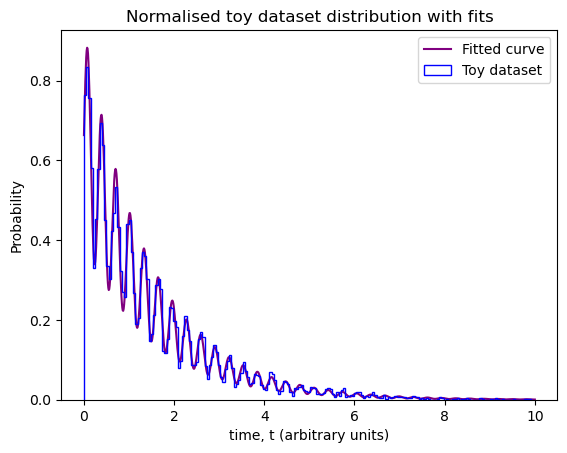

In [254]:
# Given that out nominal_pdf object currently has its parameters set to the optimised parameters, we don't have to set them
plt.plot(t, nominal_pdf.evaluate(t)/nominal_pdf.integrate(X_BOUNDS), c="purple", ls="-", label="Fitted curve")
_ = plt.hist(events, bins=200, histtype="step", label="Toy dataset", color="blue", density=True) 
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"Probability")
plt.title("Normalised toy dataset distribution with fits")
plt.legend()

Now that we see tha we are able to create an accurate fit of the toy dataset, We will create a function to generate 100 toy datasets and fit each one. The function would then store the optimised parameters s.t we can plot the distribution of optimised parameters

In [244]:
def get_optimised_values(results, parameter_keys):  
    """
    A function that will return a list of the values of the parameters stored in a migrad results table
    """
    parameter_values = []
    # Iterate over all keys
    for key in parameter_keys:
        parameter_values.append(results.params[key].value)
    return parameter_values    

# Function that will create and fit one toy dataset
def generate_and_fit_dataset(
        bounds,
        n_events=10000,
        truth_parameters=[1.5, 20.0, 0.1], 
        initial_parameters=[1.0, 25.0, 0.3]
):
    """
    Function will generate and fit one toy dataset. The structure of the parameter lists are [tau, delta mass, V]
    Returns list of paramer values in the same order as the initial parameter dictionary (and input parameter list)
    """
    # Define initial parameter dictionary
    initial_parameters = {
        "tau"       : 1.2,
        "deltaMass" : 21.0,
        "V"         : 0.15
    }
    # Generate pdf object
    pdf = HarmonicWithDecay(*truth_parameters, bounds)
    # Generate Events
    for _ in range(n_events):
        pdf.next()
    events = pdf.getMass(flush=True)

    # Minimise the events
    negative_log_likelihood = NegativeLogLikelihood(nominal_pdf, events)
    minimiser = Minuit(negative_log_likelihood.evaluate, **initial_parameters)
    # Limit the range of possible values parameters to sensible values given the assumptions mentioned above
    minimiser.limits = [(1.0, 2.0), (17.0, 23.0), (0.0, 0.3)]
    results = minimiser.migrad()

    # Return list of paramer values in the same order as the initial parameter dictionary
    return get_optimised_values(results, initial_parameters.keys())

Using these functions, we can now loop over it 100 times to obtain out optimised parameters

In [245]:
# Define parameters forgen and fit function for testing
n_events = 10000
truth_parameters = [1.5, 20.0, 0.1]
n_toy_datasets = 50

# Define empty lists to hold optimised parameters (Three nested lists to contain each parameter)
optimised_parameters_dict = {
    "optimised_tau":          [],
    "optimised_delta_mass":   [],
    "optimised_V":            [],
}

# Loop over fitting function 100 times
for _ in range(n_toy_datasets):
    # Generate fit and find optimised params
    optimised_parameters = generate_and_fit_dataset(bounds=X_BOUNDS, n_events=n_events, truth_parameters=truth_parameters)

    # Append each optimised parameter to list in dictionary
    for idx, key in enumerate(optimised_parameters_dict):
        optimised_parameters_dict[key].append(optimised_parameters[idx])

# Convert lists in dictionary to numpy arrays
for key in optimised_parameters_dict:
    optimised_parameters_dict[key] = np.array(optimised_parameters_dict[key])

We can now compute the precision of each of our optimised parameters by taking the mean value of the optimised parameter lists

In [246]:
# Compute the precision
tau_precision = optimised_parameters_dict["optimised_tau"].mean()
delta_mass_precision = optimised_parameters_dict["optimised_delta_mass"].mean()
V_precision = optimised_parameters_dict["optimised_V"].mean()

# Output precision of each parameter
print(f"The precision on the tau parameter for our MC simulation is {tau_precision:.3f} arbitrary units\n")
print(f"The precision on the delta mass parameter for our MC simulation is {delta_mass_precision:.3f} arbitrary units\n")
print(f"The precision on the V parameter for our MC simulation is {V_precision:.3f} arbitrary units")

The precision on the tau parameter for our MC simulation is 1.471 arbitrary units

The precision on the delta mass parameter for our MC simulation is 20.056 arbitrary units

The precision on the V parameter for our MC simulation is 0.098 arbitrary units


# ASK ABOUT THE FITING ON V PROBLEM

Now that we have 100 sets of optimised parameters, we can plot the distributuion for each optimised parameters and see how they are distributed

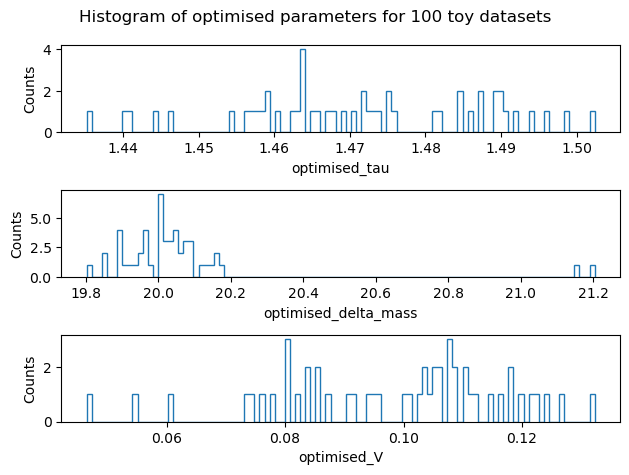

In [247]:
fig, axes = plt.subplots(3,1)

for idx, key in enumerate(optimised_parameters_dict):
    # Plot a histogram of the optiised value
    _ = axes[idx].hist(optimised_parameters_dict[key], bins=100, histtype="step")
    axes[idx].set_ylabel("Counts")
    axes[idx].set_xlabel(key)
fig.suptitle("Histogram of optimised parameters for 100 toy datasets")
fig.tight_layout()

# Ask if Poisson w/ large $\mu$ or if gaussian

The values for the optimised parameters we are obtaining are drawn from a poisson distribution. However, given that we have a large number of optimised parameters, we can use the poiussin's distributions's large mean approximation and approximate it to a gaussian distribution. Hence with this, we can obtain the bias (uncertanty) on the precision (mean) of our optimised parameters by computing the standard error on the mean for a gaussian:

\begin{equation}
\delta\mu = \frac{\mu}{\sqrt{N}}
\end{equation}

where N is the number of optimised parameters (given by the number of toy expewriments we ran).

Below we compute and print the biases on the precisions of the parameters for our MC simualtions

In [248]:
# Compute the bias
tau_bias = optimised_parameters_dict["optimised_tau"].mean() / np.sqrt(n_toy_datasets)
delta_mass_bias = optimised_parameters_dict["optimised_delta_mass"].mean() / np.sqrt(n_toy_datasets)
V_bias = optimised_parameters_dict["optimised_V"].mean() / np.sqrt(n_toy_datasets)

# Output precision of each parameter
print(f"The precision and bias on the tau parameter for our MC simulation is {tau_precision:.3f} +/- {tau_bias:.3f} arbitrary units\n")
print(f"The precision and bias on the delta mass parameter for our MC simulation is {delta_mass_precision:.3f} +/- {delta_mass_bias:.3f} arbitrary units\n")
print(f"The precision and bias on the V parameter for our MC simulation is {V_precision:.3f} +/- {V_bias:.3f} arbitrary units")

The precision and bias on the tau parameter for our MC simulation is 1.471 +/- 0.208 arbitrary units

The precision and bias on the delta mass parameter for our MC simulation is 20.056 +/- 2.836 arbitrary units

The precision and bias on the V parameter for our MC simulation is 0.098 +/- 0.014 arbitrary units
